<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [ ]:
# If running in Colab

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/memit
git clone https://github.com/kmeng01/memit memit > install.log 2>&1
pip install -r /content/memit/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = True
try:
    import google.colab
    import torch
    import os

    IS_COLAB = True
    os.chdir("/content/memit")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
# Causal Tracing

In [ ]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate

In [ ]:
import os, re, json
import matplotlib.pyplot as plt
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

In [ ]:
model_name = "gpt2-xl"  
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [ ]:
with open('/content/correct_capitals_predicted.txt', 'r') as file:
    sentences = [line.strip() for line in file]

c = 0
unique_sentence = []
for s in sentences:
  s1 = ' '.join(s.split()[:-1])
  ans = predict_token(
      mt,
      [s1],
      return_p=True,
    )[0][0]
  print(s1 + ans)

Kabul is the capital of Afghanistan
Tirana is the capital of Albania
Algiers is the capital of Algeria
Pago Pago is the capital of American Samoa
Luanda is the capital of Angola
St. John's is the capital of Antigua And Barb
Buenos Aires is the capital of Argentina
Yerevan is the capital of Armenia
Canberra is the capital of Australia
Vienna is the capital of Austria
Baku is the capital of Azerbaijan
Dhaka is the capital of Bangladesh
Brussels is the capital of Belgium
Sarajevo is the capital of Bosnia and Herz
Brasilia is the capital of Brazil
Diego Garcia is the capital of British Indian Ocean Territory
Sofia is the capital of Bulgaria
Ouagadougou is the capital of Burkina Fas
Phnom Penh is the capital of Cambodia
Ottawa is the capital of Canada
Praia is the capital of Cape Ver
George Town is the capital of Cayman Islands
Bangui is the capital of Central African Republic
Beijing is the capital of China
Flying Fish Cove is the capital of Christmas Island
West Island is the capital of C

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [ ]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")


In [ ]:
knowns.data

In [ ]:
def extract_prompts_by_relation(knowns, relation_id):
    prompts = [known['prompt'] for known in knowns if known['relation_id'] == relation_id]
    return prompts


relation_id = 'P112'  # Change this to the relation_id you want to extract prompts for
prompts = extract_prompts_by_relation(knowns.data, relation_id)
print(len(prompts))

In [ ]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [ ]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    subj_prob = 0
   
    differences, subj_prob = trace_important_window(
        mt.model,
        mt.num_layers,
        inp,
        e_range,
        answer_t,
        noise=noise,
        window=window,
        kind=kind,
    )
    differences = differences.detach().cpu()
  
    return (dict(
    scores=differences,
    low_score=low_score,
    high_score=base_score,
    input_ids=inp["input_ids"][0],
    input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
    subject_range=e_range,
    answer=answer,
    window=window,
    kind=kind or "",

), subj_prob)



def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )


            row.append(r)

        table.append(torch.stack(row))

    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )

            row.append(r)
        table.append(torch.stack(row))

    return torch.stack(table), torch.stack(table)[e_range[1] - 1]

## Code to plot the results

In [ ]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):

    if subject is None:
        subject = guess_subject(prompt)

    result, subj_prob = calculate_hidden_flow(
      mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )

    return subj_prob




def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    subj_prob = 0
    for kind in ["mlp"]: #[None, "mlp", "attn"]:
        subj_prob = plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )
    return subj_prob



The following prompt can be changed to any factual statement to trace.

In [ ]:
with open('/content/correct_capitals_predicted.txt', 'r') as file:
    sentences = [line.strip() for line in file]

In [ ]:
prompts = []
for s in sentences:
  word = 'capital of'
  index = s.find(word) + 10
  result = s[:index]
  prompts.append(result)

In [ ]:
prompts

['Kabul is the capital of',
 'Tirana is the capital of',
 'Algiers is the capital of',
 'Pago Pago is the capital of',
 'Luanda is the capital of',
 "St. John's is the capital of",
 'Buenos Aires is the capital of',
 'Yerevan is the capital of',
 'Canberra is the capital of',
 'Vienna is the capital of',
 'Baku is the capital of',
 'Dhaka is the capital of',
 'Brussels is the capital of',
 'Sarajevo is the capital of',
 'Brasilia is the capital of',
 'Diego Garcia is the capital of',
 'Sofia is the capital of',
 'Ouagadougou is the capital of',
 'Phnom Penh is the capital of',
 'Ottawa is the capital of',
 'Praia is the capital of',
 'George Town is the capital of',
 'Bangui is the capital of',
 'Beijing is the capital of',
 'Flying Fish Cove is the capital of',
 'West Island is the capital of',
 'Bogota is the capital of',
 'Kinshasa is the capital of',
 'Avarua is the capital of',
 'San Jose is the capital of',
 'Yamoussoukro is the capital of',
 'Havana is the capital of',
 'Nicosia

In [ ]:
with open('/content/correct_capitals_predicted.txt', 'r') as file:
    sentences = [line.strip() for line in file]
import pandas as pd
c = 0
unique_sentence = []
df = pd.DataFrame({})
for p in prompts:

  val = plot_all_flow(mt, p, subject = p, noise=noise_level)
  temp_df = pd.DataFrame(val.cpu().numpy()).transpose()
  df = pd.concat([df, temp_df])
  df.to_csv('df_causal_capitals_relations_corruption.csv')


In [ ]:
df.index = range(len(df))
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.060747,0.074270,0.083206,0.098552,0.186061,0.221279,0.292871,0.259959,0.210493,0.204492,...,0.009814,0.009046,0.008820,0.008520,0.008584,0.008440,0.008328,0.008450,0.008471,0.008511
1,0.002218,0.002108,0.002388,0.002670,0.003053,0.004296,0.001849,0.003106,0.002206,0.001885,...,0.001652,0.001644,0.001582,0.001586,0.001561,0.001533,0.001548,0.001552,0.001553,0.001538
2,0.035255,0.027758,0.030192,0.023806,0.028420,0.046916,0.007170,0.019616,0.002144,0.003033,...,0.000565,0.000500,0.000508,0.000489,0.000494,0.000493,0.000495,0.000487,0.000482,0.000480
3,0.940870,0.956667,0.954245,0.952882,0.952290,0.954105,0.939200,0.943067,0.926313,0.825744,...,0.778489,0.780515,0.776483,0.775294,0.773518,0.775742,0.779652,0.783981,0.788474,0.787182
4,0.195119,0.185872,0.174855,0.165116,0.137692,0.216144,0.190696,0.140421,0.023659,0.039597,...,0.001910,0.001869,0.001824,0.001781,0.001704,0.001724,0.001690,0.001676,0.001661,0.001686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.202862,0.229917,0.234444,0.223348,0.208742,0.304641,0.237984,0.361336,0.311698,0.434158,...,0.109165,0.106408,0.105890,0.105264,0.105990,0.106485,0.106508,0.106326,0.105947,0.106378
172,0.153177,0.153812,0.111983,0.051199,0.058909,0.130993,0.124503,0.080241,0.029864,0.184482,...,0.003590,0.003320,0.003457,0.003438,0.003362,0.003384,0.003338,0.003399,0.003424,0.003422
173,0.476304,0.476115,0.475105,0.475051,0.474995,0.475004,0.308066,0.109413,0.095343,0.052866,...,0.034456,0.034482,0.034491,0.034506,0.034227,0.034221,0.034223,0.034242,0.034225,0.034240
174,0.001367,0.001204,0.001236,0.001674,0.001371,0.001355,0.006854,0.012784,0.001254,0.004532,...,0.000828,0.000765,0.000739,0.000717,0.000707,0.000703,0.000696,0.000686,0.000679,0.000681


In [ ]:
df.to_csv('df_causal_trace_capitals.csv')

In [ ]:
import numpy as np
avg_prob_values = [x.cpu() for x in subj_prob_list]

In [ ]:
np.save("/content/avg_prob_list_171_sports_persons", avg_prob_values)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
import numpy as np
a = np.load('/content/avg_prob_list_171_sports_persons.npy', allow_pickle=True)
a1 = np.array([t.numpy() for t in a])
a2 = np.mean(a1, axis = 0)
a2

array([0.16645975, 0.16632101, 0.16646166, 0.16755114, 0.16604756,
       0.17036419, 0.15596087, 0.16378658, 0.13922569, 0.12692472,
       0.14339289, 0.18409427, 0.21945329, 0.25343537, 0.27328938,
       0.291614  , 0.30043176, 0.3084309 , 0.29436252, 0.27651212,
       0.25700608, 0.22214477, 0.17563446, 0.15555021, 0.14000382,
       0.11764898, 0.11090898, 0.1040626 , 0.09723274, 0.0952647 ,
       0.09263748, 0.09030055, 0.09114376, 0.08375465, 0.0822337 ,
       0.07986078, 0.07634456, 0.07490465, 0.07448044, 0.07350657,
       0.07263952, 0.07179201, 0.07140936, 0.07112   , 0.0707576 ,
       0.07062507, 0.0705657 , 0.07054229], dtype=float32)

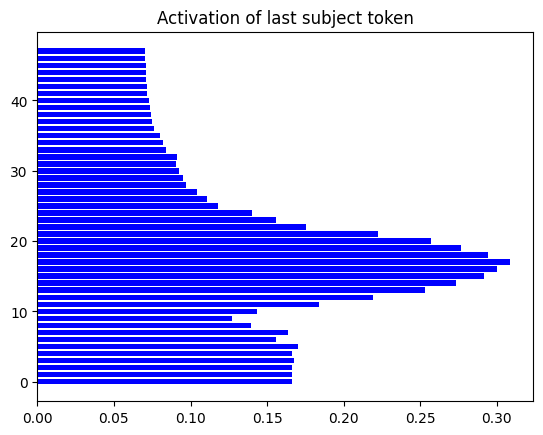

In [ ]:
fig, ax = plt.subplots()
ax.barh(range(len(a2)), a2, color='blue')
ax.set_title('Activation of last subject token')
plt.show()


In [ ]:
plot_all_flow(mt, "Delhi is the capital of", noise=noise_level)

tensor([0.1276, 0.1557, 0.2086, 0.1963, 0.2388, 0.3369, 0.4250, 0.5110, 0.5275,
        0.5653, 0.5019, 0.4736, 0.4455, 0.4534, 0.5112, 0.4283, 0.2913, 0.2026,
        0.1666, 0.1152, 0.0723, 0.0584, 0.0564, 0.0455, 0.0409, 0.0439, 0.0401,
        0.0436, 0.0410, 0.0367, 0.0348, 0.0335, 0.0342, 0.0197, 0.0182, 0.0174,
        0.0160, 0.0165, 0.0163, 0.0174, 0.0176, 0.0170, 0.0173, 0.0173, 0.0178,
        0.0181, 0.0181, 0.0181], device='cuda:0')

Here we trace a few more factual statements from a file of test cases.

In [ ]:
# Checking the modules of the GPT2XL model

In [ ]:
mt.model.modules

<bound method Module.modules of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)>

In [ ]:
# Example predictions

In [ ]:
predict_token(
    mt,
    ["eBay is founded by"],
    return_p=True,
)

([' Pierre'], tensor([0.3581], device='cuda:0'))

In [ ]:
predict_token(
    mt,
    ["Google is founded by", "Microsoft is founded by", "Netflix is founded by"],
    return_p=True,
)

([' Larry', ' Bill', ' Reed'],
 tensor([0.1886, 0.1331, 0.2358], device='cuda:0'))

In [ ]:
predict_token(
    mt,
    ["Porsche Holding is founded by"],
    return_p=True,
)

([' Ferdinand'], tensor([0.5067], device='cuda:0'))

In [ ]:
# Plotting the examples

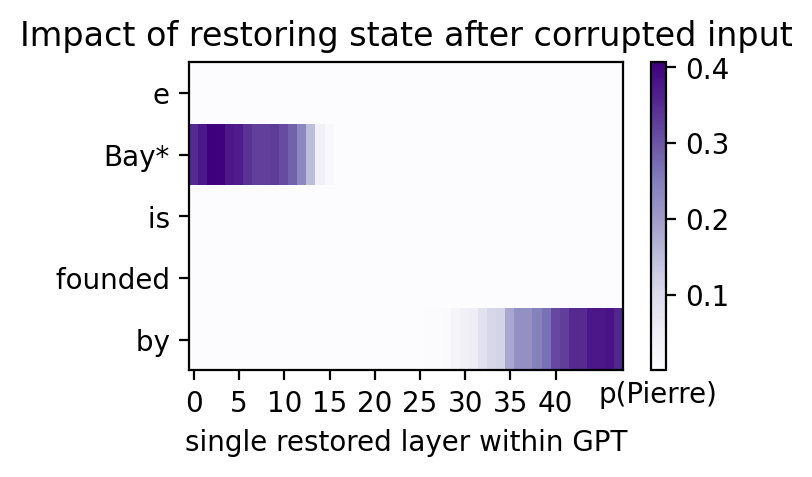

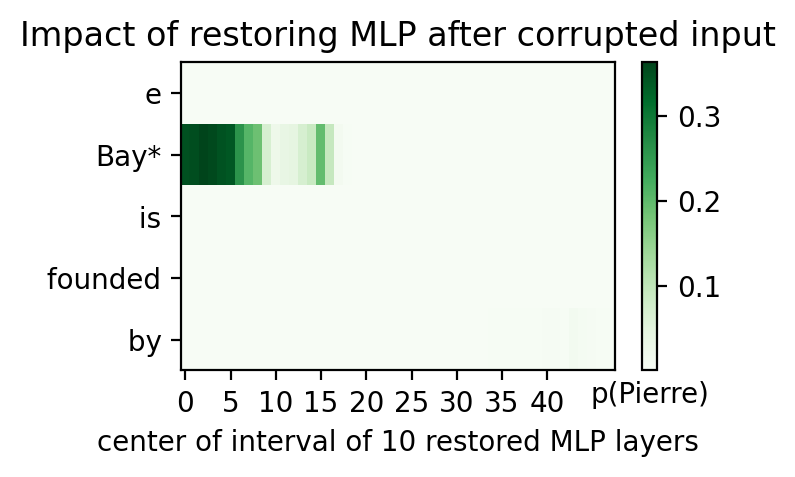

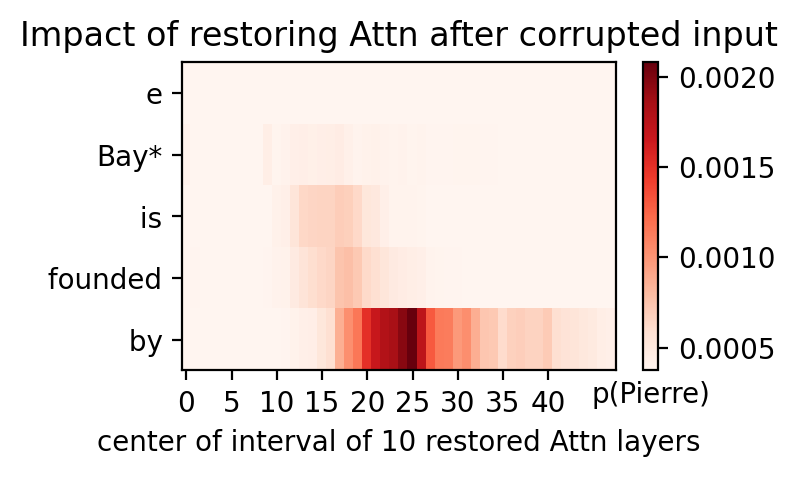

In [ ]:
plot_all_flow(mt, "eBay is founded by", noise=noise_level)

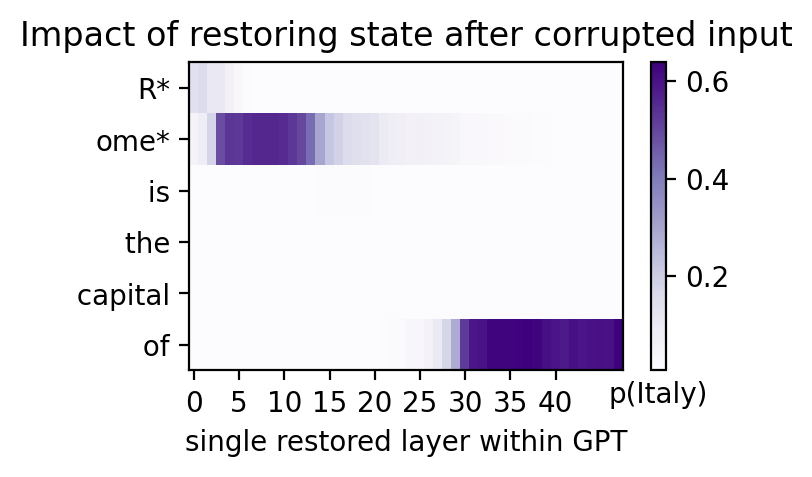

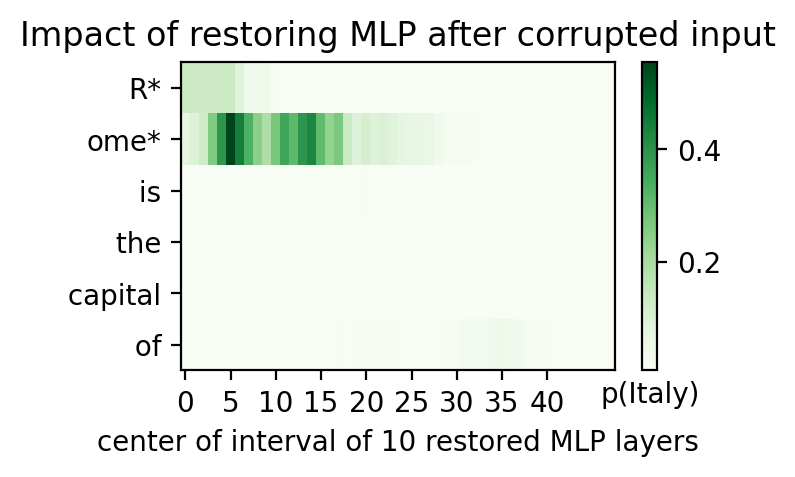

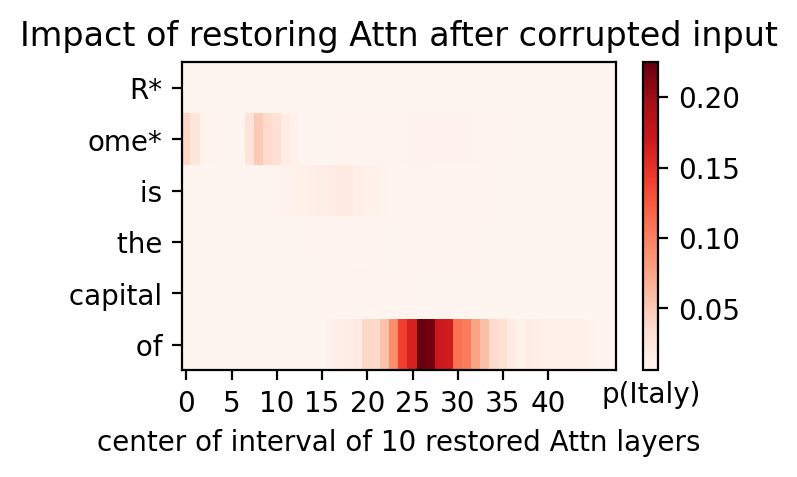

In [ ]:
plot_all_flow(mt, "Rome is the capital of", noise=noise_level)

{'scores': tensor([[0.2140, 0.2224, 0.2387, 0.2236, 0.1903, 0.1153, 0.0331, 0.0129, 0.0097,
         0.0093, 0.0087, 0.0086, 0.0086, 0.0086, 0.0086, 0.0087, 0.0086, 0.0086,
         0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085,
         0.0085, 0.0084, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0084,
         0.0085, 0.0085, 0.0084, 0.0083, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0085, 0.0086, 0.0084],
        [0.0136, 0.0233, 0.0337, 0.0684, 0.1422, 0.2056, 0.2292, 0.2502, 0.2535,
         0.2467, 0.2431, 0.2395, 0.2355, 0.2249, 0.1947, 0.1617, 0.1389, 0.0833,
         0.0544, 0.0249, 0.0225, 0.0213, 0.0206, 0.0197, 0.0163, 0.0169, 0.0146,
         0.0136, 0.0131, 0.0135, 0.0131, 0.0121, 0.0113, 0.0113, 0.0108, 0.0103,
         0.0087, 0.0087, 0.0090, 0.0091, 0.0091, 0.0093, 0.0090, 0.0089, 0.0087,
         0.0086, 0.0086, 0.0084],
        [0.0090, 0.0099, 0.0102, 0.0106, 0.0106, 0.0103, 0.0094, 0.0086, 0.0085,
         0.0086, 0.0083, 0.008

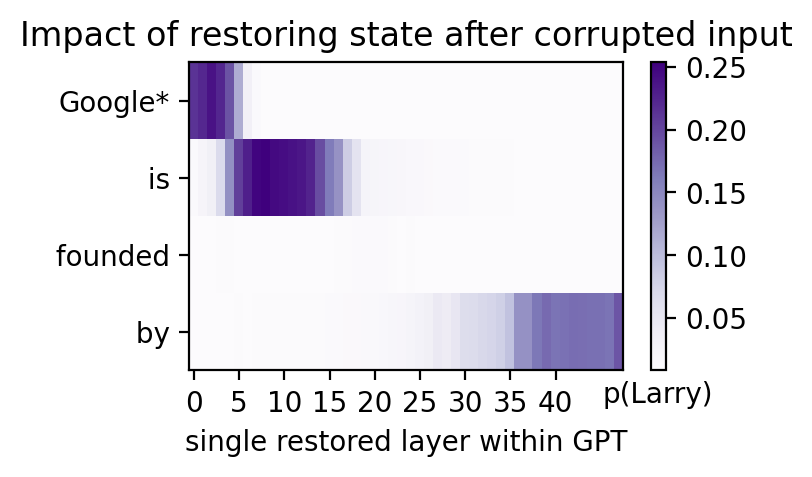

{'scores': tensor([[0.2157, 0.2144, 0.2136, 0.2142, 0.2143, 0.2144, 0.2091, 0.0888, 0.0418,
         0.0261, 0.0071, 0.0056, 0.0077, 0.0080, 0.0083, 0.0083, 0.0083, 0.0083,
         0.0083, 0.0083, 0.0083, 0.0083, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0083, 0.0083, 0.0083,
         0.0083, 0.0083, 0.0083],
        [0.0096, 0.0086, 0.0081, 0.0084, 0.0140, 0.0159, 0.0166, 0.0187, 0.0201,
         0.0250, 0.0339, 0.0302, 0.0459, 0.0406, 0.0502, 0.0472, 0.0330, 0.0333,
         0.0257, 0.0281, 0.0262, 0.0158, 0.0114, 0.0121, 0.0135, 0.0131, 0.0128,
         0.0132, 0.0134, 0.0108, 0.0106, 0.0102, 0.0101, 0.0103, 0.0107, 0.0102,
         0.0099, 0.0096, 0.0097, 0.0091, 0.0090, 0.0089, 0.0090, 0.0088, 0.0088,
         0.0087, 0.0087, 0.0086],
        [0.0101, 0.0086, 0.0098, 0.0103, 0.0091, 0.0085, 0.0085, 0.0069, 0.0067,
         0.0063, 0.0059, 0.005

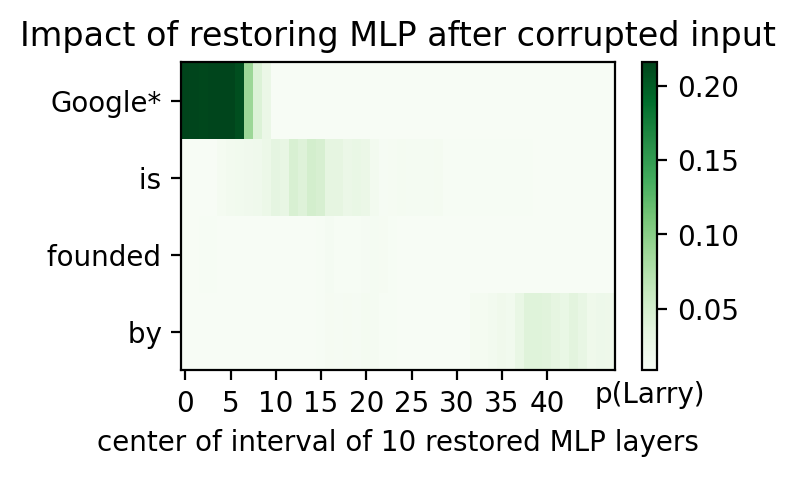

{'scores': tensor([[0.0068, 0.0041, 0.0027, 0.0025, 0.0024, 0.0024, 0.0011, 0.0009, 0.0011,
         0.0015, 0.0026, 0.0043, 0.0073, 0.0081, 0.0083, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0083, 0.0083, 0.0083],
        [0.1433, 0.2088, 0.2358, 0.2526, 0.2531, 0.2496, 0.2640, 0.2648, 0.2576,
         0.2256, 0.1648, 0.0607, 0.0170, 0.0061, 0.0056, 0.0057, 0.0061, 0.0064,
         0.0065, 0.0066, 0.0076, 0.0079, 0.0072, 0.0069, 0.0077, 0.0087, 0.0084,
         0.0082, 0.0085, 0.0086, 0.0084, 0.0084, 0.0086, 0.0086, 0.0086, 0.0085,
         0.0084, 0.0084, 0.0083, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
         0.0084, 0.0084, 0.0084],
        [0.0109, 0.0106, 0.0098, 0.0092, 0.0091, 0.0092, 0.0088, 0.0085, 0.0081,
         0.0072, 0.0077, 0.008

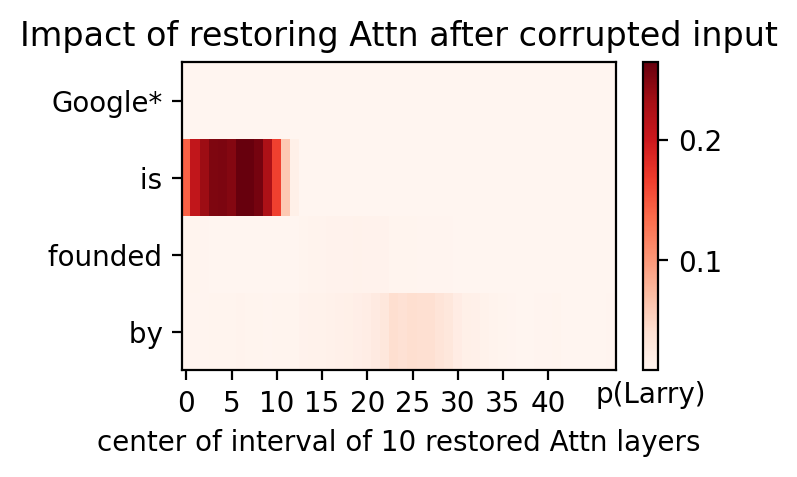

In [ ]:
plot_all_flow(mt, "Google is founded by", noise=noise_level)

In [ ]:
mlp_layers_list = []
for i in range(48):
    mlp_layers_list.append('transformer.h.'+ str(i)+'.mlp')
mlp_layers_list[:5]

['transformer.h.0.mlp',
 'transformer.h.1.mlp',
 'transformer.h.2.mlp',
 'transformer.h.3.mlp',
 'transformer.h.4.mlp']

In [ ]:
prompt = "Delhi is the capital of the country of"
samples = 0   #0
subject= None
noise = 0    #0
kind = None

subject = guess_subject(prompt)

inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
with torch.no_grad():
    answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
[answer] = decode_tokens(mt.tokenizer, [answer_t])
e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

tokens = mt.tokenizer(prompt)


probs,all_traced = trace_with_patch(
    model = mt.model,  # The model
    inp = inp,  # A set of inputs
    states_to_patch = [],  # A list of (token index, layername) triples to restore
    answers_t = answer_t,  # Answer probabilities to collect
    tokens_to_mix = e_range,  # Range of tokens to corrupt (begin, end)
    noise = noise,  # Level of noise to add
    trace_layers=mlp_layers_list#['transformer.h.1.mlp','transformer.h.2.mlp','transformer.h.3.mlp','transformer.h.4.mlp','transformer.h.5.mlp', 'transformer.ln_f',] #'lm_head'],  # List of traced outputs to return
)
all_traced.shape # (samples + 1)x(number of tokens in prompt)x(length of trace_layers)x(no. of neurons)

torch.Size([1, 9, 48, 1600])

In [ ]:
probs

tensor(nan, device='cuda:0')

In [ ]:
all_traced[0,-1,:,:].shape

torch.Size([48, 1600])

In [ ]:
from matplotlib import pyplot as plt

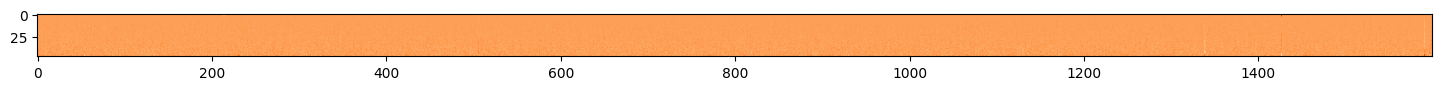

In [ ]:
plt.figure(figsize=(18, 6))
plt.imshow(all_traced[0,-1,:,:], cmap = 'Oranges_r')
plt.show()

<Axes: >

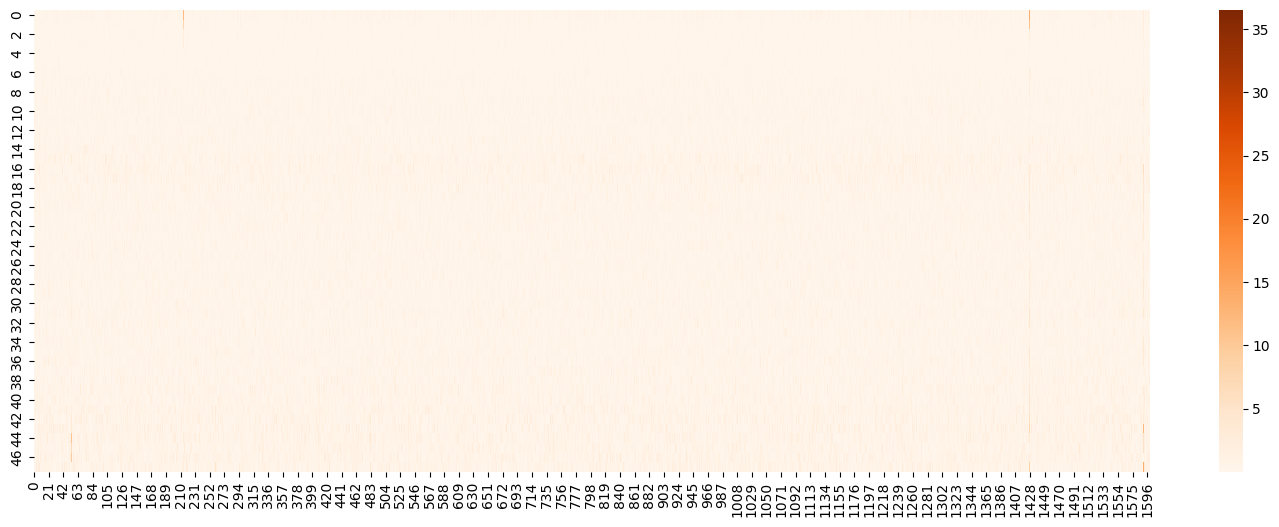

In [ ]:
import seaborn as sns
import numpy as np
# Upscale the x-dimension
fig, ax = plt.subplots(figsize=(18, 6))  # You can adjust the figsize to your preference

# Create the heat map
sns.heatmap(np.abs(all_traced[0,3,:,:]), cmap='Oranges', ax=ax)

In [ ]:
knowns.data

[{'known_id': 0,
  'subject': 'Vinson Massif',
  'attribute': 'Antarctica',
  'template': '{} is located in the continent',
  'prediction': ' of Antarctica. It is the largest of the three',
  'prompt': 'Vinson Massif is located in the continent of',
  'relation_id': 'P30'},
 {'known_id': 1,
  'subject': 'Beats Music',
  'attribute': 'Apple',
  'template': '{} is owned by',
  'prediction': ' Apple, which is also the owner of Beats Electronics',
  'prompt': 'Beats Music is owned by',
  'relation_id': 'P127'},
 {'known_id': 2,
  'subject': 'Audible.com',
  'attribute': 'Amazon',
  'template': '{} is owned by',
  'prediction': ' Amazon.com, Inc. or its affiliates.',
  'prompt': 'Audible.com is owned by',
  'relation_id': 'P127'},
 {'known_id': 3,
  'subject': 'The Big Bang Theory',
  'attribute': 'CBS',
  'template': '{} premieres on',
  'prediction': ' CBS on September 22.<|endoftext|>',
  'prompt': 'The Big Bang Theory premieres on',
  'relation_id': 'P449'},
 {'known_id': 4,
  'subject'

In [ ]:
def extract_prompts_by_relation(knowns, relation_id):
    prompts = [known['prompt'] for known in knowns if known['relation_id'] == relation_id]
    return prompts


relation_id = 'P30'  # Change this to the relation_id you want to extract prompts for
prompts = extract_prompts_by_relation(knowns.data, relation_id)
print(prompts)

['Vinson Massif is located in the continent of', 'Catalonia belongs to the continent of', 'Kirkpatrick Glacier belongs to the continent of', 'Vietnam belongs to the continent of', 'Rhine belongs to the continent of', 'Urdoviza Glacier belongs to the continent of', 'Manipur belongs to the continent of', 'Camp Academia is located in the continent of', 'Mawson Glacier belongs to the continent of', 'Schreckhorn belongs to the continent of', 'Afghanistan belongs to the continent of', 'Mount Cocks is located in the continent of', 'Gerlache Strait is located in the continent of', 'Hurricane Ridge is a part of the continent of', 'Howard Glacier belongs to the continent of', 'Kirkby Glacier belongs to the continent of', 'Emmanuel Glacier belongs to the continent of', 'Yangtze belongs to the continent of', 'Toulouse belongs to the continent of', 'Viking Age belongs to the continent of', 'Sjogren Glacier belongs to the continent of', 'Johnson Glacier belongs to the continent of', 'Chandigarh belo